## Homework 5

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Markdown

!pip install -U okpy
from client.api.notebook import Notebook
ok = Notebook('hw5.ok')

Requirement already up-to-date: okpy in /Users/juntan/anaconda3/envs/datascience/lib/python3.5/site-packages
Requirement already up-to-date: requests==2.12.4 in /Users/juntan/anaconda3/envs/datascience/lib/python3.5/site-packages (from okpy)
Assignment: Homework 5
OK, version v1.11.0



## This assignment

In this assignment we will study a fundamental problem in crawling the web: *deciding when to re-index changing pages*.  

Search engines like those deployed at Google and Microsoft periodically visit, or *crawl*, web pages to check their current status and record any changes to the page.  Some pages, such as news websites, are updated frequently while other pages, [like this one](http://youvegotmail.warnerbros.com/cmp/0frameset.html), are never updated. 

**Why not crawl the entire web all the time?**

The web is **big** and even giant search engines don't have the resources to re-read the entire web continuously.  Fortunately, different sites change at different rates, so an intuitive strategy would be to visit sites more if they are changed more frequently.  But this requires us to know, or at least estimate, how often each web site is changed.  This is the main question you'll answer in this assignment.


Along the way you will:

* do some EDA to understand the site dataset.
* build several *models* for the site changes.
* use simulation to get a concrete understanding of your models.
* compute maximum-likelihood estimates of model parameters.
* use simulation and visualization to understand the accuracy of your estimates of site change frequencies.

## Examining the data
Our dataset consists of observations for about 1000 pages over a 30-day period.  Every hour, each page was downloaded, and it was determined whether the page had been changed since the previous hour.  For the first hour, we can't tell whether it has changed, so there are 719 such "checks" for each page.

**Important fact about the data:** Not every check succeeded.  Sometimes the page failed to load, or it was otherwise impossible to tell whether it had changed since the previous hour.  These hours are **omitted** from the dataset.  A field in the dataset indicates the number of successful checks for each page.

The dataset is in JSON format in the file `crawl.json`.  For each page, we have: the URL, called `url`; the number of successful visits to the page, `number of checks`; and the checks when a change was detected, called `positive checks`.  Examine the `crawl.json` file.  You might find it convenient to load it into python using `json.load`.  The next cell two cells are provided for that.

In [3]:
# Use this cell to examine the dataset, if you like.
!head -n 25 crawl.json

[
    {
        "number of checks": 378,
        "positive checks": [
            35,
            134,
            155,
            157,
            177,
            204,
            314,
            315,
            319,
            350,
            366,
            369,
            371
        ],
        "url": "http://5eg.net/gallery/thumbnails.php?album=lastcom"
    },
    {
        "number of checks": 707,
        "positive checks": [
            552,
            604,


In [4]:
# This cell loads the JSON data into Python.
import json
with open("crawl.json", "r") as f:
    crawl_json = json.load(f)

In [5]:
crawl_json[1]

{'number of checks': 707,
 'positive checks': [552, 604, 672],
 'url': 'http://a.hatena.ne.jp/yamagen2001/'}


---

## Question 1

Fill in the function `json_description` to determine:

1. the number of records, and
2. the set of possible top level *keys* (field names) in each record.

In [6]:
def json_description(crawl_json_records):
    """Produces information about a JSON object containing crawl data.
    
    Args:
      crawl_json_records (list): A list of JSON objects such as the
                                 crawl_json variable above.
    
    Returns:
      2-tuple: An (int, set) pair.  The integer is the number of records
               in the given list.  The set is a set (constructed with
               Python's set() function) of strings.  It contains all the
               field top names that appear at the top level of any record
               in crawl_json_records.
    """
    num_records = len(crawl_json_records)
    possible_fields = set(crawl_json_records[0].keys())
    # Feel free to erase the next line.  It just demonstrates how
    # to return a tuple.  You'll have to replace the variable names
    # with whatever you define in this function.
    return (num_records, possible_fields)

In [7]:
_ = ok.grade('q01')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



In [8]:
# Display results
n, keys = json_description(crawl_json)
print("Number of records:", n)
print("Keys in the records:", keys)

Number of records: 1000
Keys in the records: {'number of checks', 'url', 'positive checks'}


---

## Question 2
What is the granularity of the dataset as represented in `crawl.json`?  Write a one to two sentence description in the cell below:

In [9]:
# Use this cell for your explorations.
q2_answer = r"""

The data is really detailed. It represents the number of time the data is successfully recorded and when the website
is updated

"""

display(Markdown(q2_answer))



The data is really detailed. It represents the number of time the data is successfully recorded and when the website
is updated




---

## Question 3

It will be more convenient to work with the data in Pandas DataFrame with a rectangular format.  Fill in the function `make_crawls_dataframe` in the cell below.  **Then** run the cell below that to create the table `crawls`.

In [10]:
def make_crawls_dataframe(crawl_json_records):
    """Creates a Pandas DataFrame from the given list of JSON records.
    
    The DataFrame corresponds to the following relation:

        crawls(primary key (url, hour), updated)

    Each hour in which a crawl happened for a page (regardless of
    whether it found a change) should be represented.  `updated` is
    a boolean value indicating whether the check for that hour found
    a change.

    The result is sorted by URL in ascending order and **further**
    sorted by hour in ascending order among the rows for each URL.
    
    Args:
      crawl_json_records (list): A list of JSON objects such as the
                                 crawl_json variable above.
    
    Returns:
      DataFrame: A table whose schema (and sort order) is described
                 above.
    """
    num_of_records, keys = json_description(crawl_json_records)
    urls = []
    hours = []
    updated = []
    for i in range(num_of_records):
        url = crawl_json_records[i]['url']
        positive_checks = crawl_json_records[i]['positive checks']
        num_of_checks = crawl_json_records[i]['number of checks']
        for h in range(1, num_of_checks+1):
            urls.append(url)
            hours.append(h)
            if h in positive_checks:
                updated.append(True)
            else:
                updated.append(False)
    result = pd.DataFrame({'url': urls, 'hour': hours, 'updated': updated})
    result = result.sort_values(['url','hour'], ascending=[True,True])
    result = result[['url', 'hour', 'updated']]
    result = result.set_index(['url', 'hour'])
    return result

In [11]:
# Run this cell before you continue.
crawls = make_crawls_dataframe(crawl_json)

In [12]:
_ = ok.grade('q03')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



## Question 4
There are other reasonable ways to represent the data in a relational database (or in DataFrames).  One alternate schema uses 2 relations to represent the data.  The first relation is:

    crawls_that_found_changes(primary key (url, hour))

The primary key for the second relation is `url`.  Define a schema for that 2nd relation.  Your schema should ensure that the two resulting tables could be used to answer any question that could be answered using `crawls`.

In [13]:
# Use this cell for your explorations.  Write the schema
# in text in the string below.
q4_answer = r"""

crawls_when_url_changes(primary key (url))

"""

display(Markdown(q4_answer))



crawls_when_url_changes(primary key (url))




---

## Question 5

In the following we will construct visualizations to understand several key quantities of interest.  The following cell constructs some key summary statistics that we will be using in the next few questions.

In [14]:
crawl_stats = (
    crawls['updated']
        .groupby(crawls.index.get_level_values('url'))
        .agg({
            'number of crawls': 'count', 
            'proportion of updates': 'mean', 
            'number of updates': 'sum'
        })
)

In [15]:
crawl_stats.head()

,number of updates,number of crawls,proportion of updates
url,,,
http://0968797090.blinklist.com/tag/%E5%8F%B0%E5%8C%97%E9%A0%82%E9%BB%9E%E7%AE%A1%E7%90%86%E5%A7%94%E5%93%A1%E6%9C%83/,0.0,245,0.000000
http://202.155.15.208/koran_detail.asp?id=283292&kat_id=16&kat_id1=&kat_id2=,27.0,217,0.124424
http://5eg.net/gallery/thumbnails.php?album=lastcom,13.0,378,0.034392
http://5eg.net/gallery/thumbnails.php?album=lastcom&cat=0,13.0,378,0.034392
http://86door.com.cn/,5.0,268,0.018657


### Part 1:

What was the distribution of the number of crawls for each page?  Did most get crawled all 719 times?  (For this and the other parts of this question, create a *visualization* to answer the question.)

Not all of the urls get 719 times.

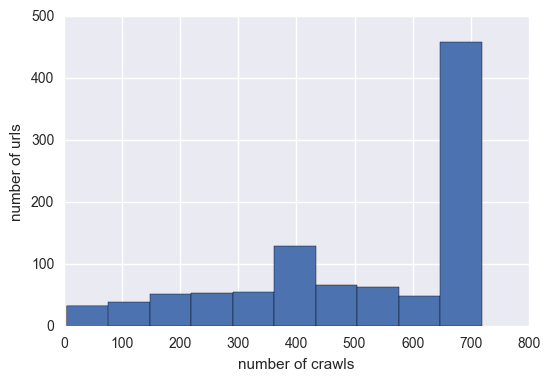

In [16]:
plt.hist(crawl_stats['number of crawls'])
plt.xlabel('number of crawls')
plt.ylabel('number of urls')

# Leave this for grading purposes
q5_p1_plot = plt.gcf()

### Part 2

What was the distribution of the number of positive checks for each page?

A lot of urls have less than 100 updates.

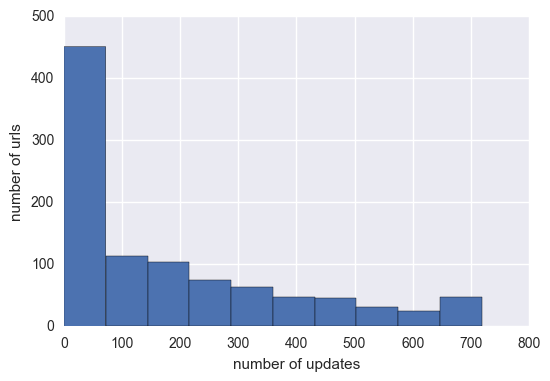

In [17]:
plt.hist(crawl_stats['number of updates'])
plt.xlabel('number of updates')
plt.ylabel('number of urls')

# Leave this for grading purposes
q5_p2_plot = plt.gcf()

### Part 3

What is the relationship between the number of crawls for each page and the number of positive checks? Construct a scatter plot relating these two quantities.

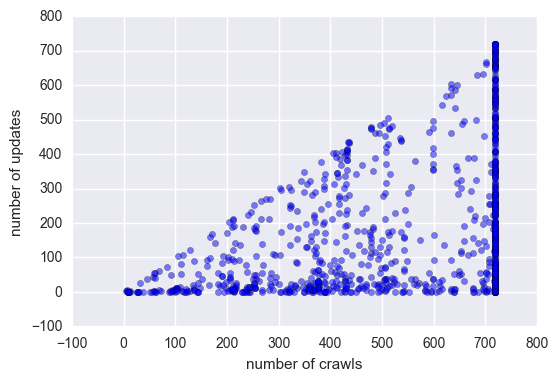

In [18]:
plt.scatter(x = crawl_stats['number of crawls'], y = crawl_stats['number of updates'], alpha=0.5)
plt.xlabel('number of crawls')
plt.ylabel('number of updates')

# Leave this for grading purposes
q5_p3_plot = plt.gcf()

### Part 4

In 2 or 3 sentences, describe what you discovered in your initial explorations.

In [19]:
q5_p4_answer = r"""

There are lots of urls do not get 719 crawls. And a lot of urls have less than 100 updates.

"""

display(Markdown(q5_p4_answer))



There are lots of urls do not get 719 crawls. And a lot of urls have less than 100 updates.



#### Making a timeline from one site

It will be useful to be able to look at timelines of positive checks or changes for sites.  The function `display_points`, defined below, will help.

In [20]:
def display_points(points, xlim, title):
    """Displays a timeline with points on it.
    
    Args:
      points (ndarray): A list of floats in the range [xlim[0], xlim[1]],
                        each one a point to display in the timeline.
      xlim (list-like): A list/tuple/array with 2 elements giving the
                        start and end of the timeline.
      title (str): The title to display on the plot.
      
    Example:
        >>> # plot the points at [1,3,30,50]
        >>> display_points([1,4,30,50], [0, 75], "Example")
    """
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 1)
    ax.scatter(points, np.repeat(0, len(points)), alpha=0.5)
    ax.axhline(0, color="grey", zorder=-1, lw=.5)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(True)
    ax.set_xlim(xlim)
    ax.set_title("{} ({:d} total points)".format(title, len(points)))
    plt.show()

#### Example Usage

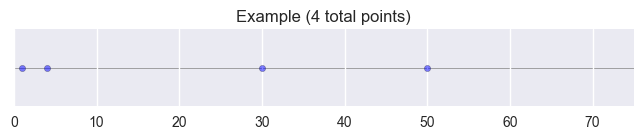

In [21]:
display_points([1,4,30,50], [0, 75], "Example")


---

## Question 6

We want to understand the behavior of page changes in order to determine how often a page should be visited. To do this, we need more than summary statistics of the 1000 sites.  We also need to examine the patterns of positive checks for sites. Let's examine when the positive checks occurred for a handful of sites.  The `display_points` function is helpful here.

We selected a variety of sites - some changed frequently, others rarely, and some had only a few successful crawls. Their URLs are available in `pages_to_display`.  Use `display_points` to examine each page.  You should notice that the visualization is not very informative in the last 3 cases.

In [22]:
# This cell identifies a few categories of pages and 
# associates a label in the 'Desc' column of crawl_stats

crawl_stats['Desc'] = "" # default blank description

# Normal pages have a moderate number of updates and 
# were successfully crawled most times.
crawl_stats.loc[
        (crawl_stats['proportion of updates'] > 0.1)
        & (crawl_stats['proportion of updates'] < 0.9)
        & (crawl_stats['number of crawls'] >= 700), 
    'Desc'] = 'Normal'

crawl_stats.loc[
        (crawl_stats['proportion of updates'] < .1)
        & (crawl_stats['number of crawls'] >= 700), 
    'Desc'] = 'Rare Update'

crawl_stats.loc[
        (crawl_stats['proportion of updates'] > .9)
        & (crawl_stats['number of crawls'] >= 700), 
    'Desc'] = 'Frequent Update'

crawl_stats.loc[
        crawl_stats['number of crawls'] < 50, 
    'Desc'] = 'Few Crawls'


# Build a dataframe with a few examples from each type of webpage
num_of_each = 3
pages_to_display = pd.concat([
    crawl_stats[crawl_stats['Desc'] == "Normal"].head(num_of_each),
    crawl_stats[crawl_stats['Desc'] == 'Rare Update'].head(num_of_each),
    crawl_stats[crawl_stats['Desc'] == 'Frequent Update'].head(num_of_each),
    crawl_stats[crawl_stats['Desc'] == 'Few Crawls'].head(num_of_each),
])

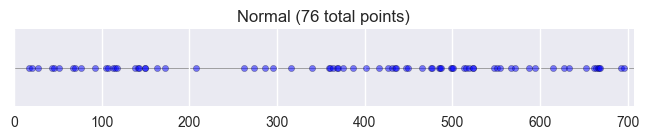

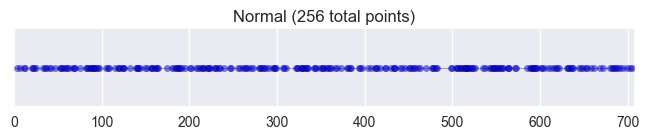

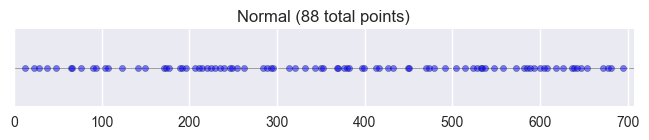

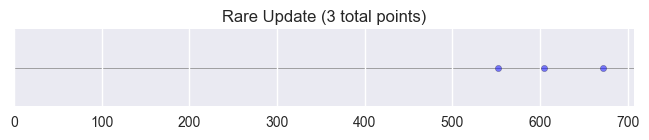

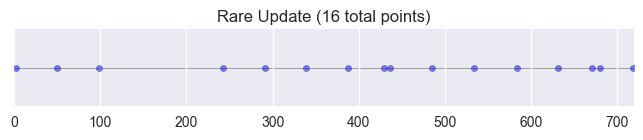

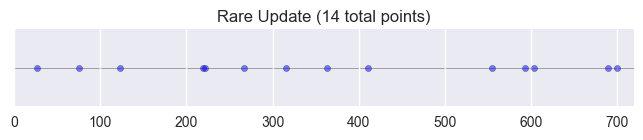

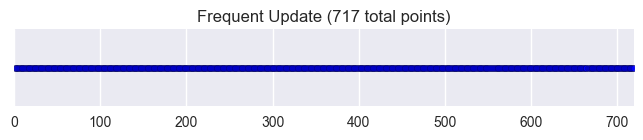

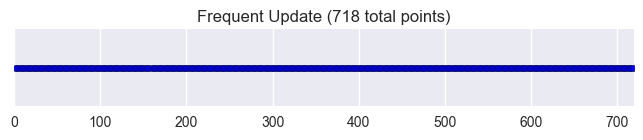

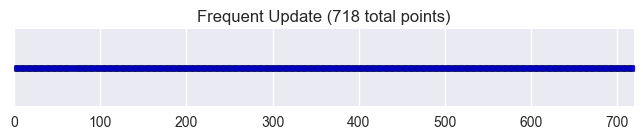

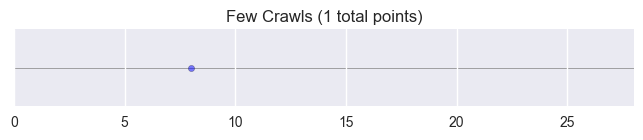

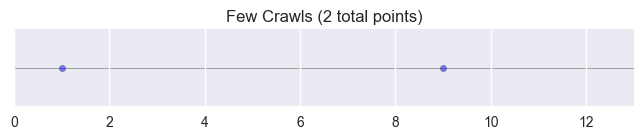

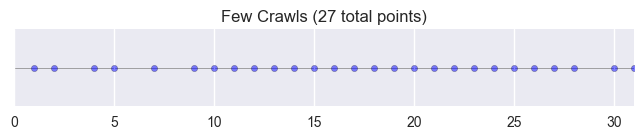

In [23]:
# Construct the timeline point diagrams for each example
for (url, desc) in pages_to_display['Desc'].iteritems():
    crawls_for_site = crawls.loc[url]
    display_points(
        crawls_for_site[crawls_for_site['updated']].index,
        [0, len(crawls_for_site)], desc)

## Examining the Times of Positive Checks

Consider what you learned about the positive checks in the previous question. Do these occur at regular intervals? Or do they appear to occur more *randomly* in time?  Write a 2 to 3 sentence explanation of what you see:

In [24]:
# Use this cell for your explorations.
q6_answer = r"""

Urls in the normal category have a more randomly updated interval. Urls that frequently update update in every single 
check, whereas urls have few updates or rare updates update at a nearly regular interval.

"""

display(Markdown(q6_answer))



Urls in the normal category have a more randomly updated interval. Urls that frequently update update in every single 
check, whereas urls have few updates or rare updates update at a nearly regular interval.



Understanding this distribution of positive checks will help us determine the distribution of changes. However, determining this distribution is difficult to do if we do not crawl the page sufficiently often. (We will soon see that it is also hard to do if the site changed too many times.) For these reasons, we will focus on "normal" pages, i.e., pages that were successfully crawled at least 700 times and that had between 50 and 200 updates.

Do the positive checks occur uniformly at random? Let's compare the observed distribution of the positive checks to the uniform distribution for a few of our pages. 


---

## Question 7

To compare the data distribution to a hypothetical probability distribution, we can compare the histogram of the data to the probability density function.  However, a more effective comparison is to compare the quantiles of the observed distribution to those of the  probability distribution. 

The $q^{th}$ quantile of the data, for $0 < q < 1$ is that point $x_q$ such that at least $q$ of the observations are at or below $x_q$ and at least $1-q$ of the observations are at or above $x_q$. For example, the median is the 0.5 quantile and the lower and upper quartiles are the 0.25 and 0.75 quantiles.

The $q^{th}$ quantile of a continuous probability distribution, for $0 < q < 1$ is that point $x_q$ such that 
$P(X \leq x_q) = q$ and $P(X \geq x_q) = 1-q$. The quantiles of a uniform distribution are easy to compute. For example, for a Uniform$(0, N)$ distribution, we have $x_q = qN$.

If the data come from the same probability distribution, then their quantiles should roughly match.  If we make a scatter plot of pairs of the empirical and theoretical quantiles, like these 3 points:

    (lower quartile of the data, lower quartile of the pdf),
    (median of data, median of the pdf),
    (upper quartile of the data, upper quartile of the pdf)

...the points should fall roughly on a line.

Such a plot is called a quantile-quantile or Q-Q plot.  For the websites with `Desc = 'Normal'` websites in `pages_to_display`, make a Q-Q plot for that site's updates, as follows:

* Let $N$ be the number of crawls for this page and $n$ be the number of positive checks.
* Order the positive check values for a site from smallest to largest. We use these as the quantiles. That is, the $k^{th}$ smallest observation is the $k/(n+1)$-quantile.
* Compute the $n$ corresponding quantiles for the uniform distribution on $(0, N)$. These are simply
$$k \times \frac{N}{n+1},$$
for $k = 1, \ldots, n$.  (Why?)
* Plot the $n$ pairs of quantiles in a scatter plot.

In [25]:
pages_to_display.head()

,number of updates,number of crawls,proportion of updates,Desc
url,,,,
http://a.hatena.ne.jp/Syako/simple,76.0,707,0.107496,Normal
http://a.hatena.ne.jp/inouetom/image?gid=null,256.0,707,0.362093,Normal
http://a.hatena.ne.jp/munehiro/simple,88.0,707,0.124470,Normal
http://a.hatena.ne.jp/yamagen2001/,3.0,707,0.004243,Rare Update
http://bidders.selfip.net/Books/531454/5801,16.0,719,0.022253,Rare Update


In [26]:
normal_df = pages_to_display.reset_index(drop=False)
normal_df[normal_df['url'] == "http://a.hatena.ne.jp/Syako/simple"].head()

,url,number of updates,number of crawls,proportion of updates,Desc
0,http://a.hatena.ne.jp/Syako/simple,76.0,707,0.107496,Normal


### Part 1

In [27]:
def compute_q_q_pairs(url):
    """Computes lists of uniform-distribution-quantiles and data-quantiles for a page.
    
    Args:
      url (str): The URL of a page.
    
    Returns:
      2-tuple: A pair (AKA a 2-tuple).  Both components are lists or arrays of
               length n, where n is the number of positive checks for the page.
               The first component contains quantiles of a uniform distribution,
               and the second contains quantiles of the distribution of positive
               check times for the page.  The kth element of a component is the
               (k+1)/(n+1)-th quantile of its distribution or dataset.
               
               The first component of the pair contains quantiles of the uniform
               distribution on [0, N], where N is the number of checks performed
               for the page.
    """
    for d in crawl_json:
        if d['url'] == url:
            N = d['number of checks']
            n = len(d['positive checks'])
            pos_checks = d['positive checks']
            break
    
    obs_q = pos_checks
    pdf_q = []
    for k in range(1, n+1):
        pdf_q.append(k * N/(n+1))
    
    return (np.array(pdf_q), np.array(obs_q))

In [28]:
pdf_q, obs_q = compute_q_q_pairs("http://a.hatena.ne.jp/Syako/simple") 
int(np.mean(obs_q))

372

In [29]:
int(np.std(pdf_q - obs_q))

30

In [30]:
_ = ok.grade('q07')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



The following code constructs the final Q-Q plot for the `"Normal"` sites defined above

http://a.hatena.ne.jp/Syako/simple


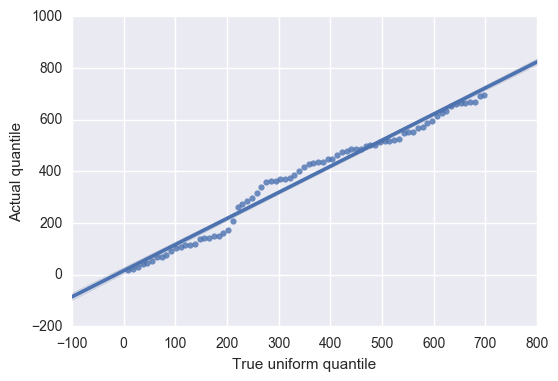

http://a.hatena.ne.jp/inouetom/image?gid=null


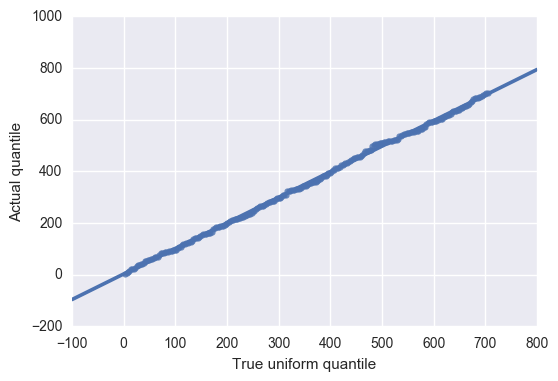

http://a.hatena.ne.jp/munehiro/simple


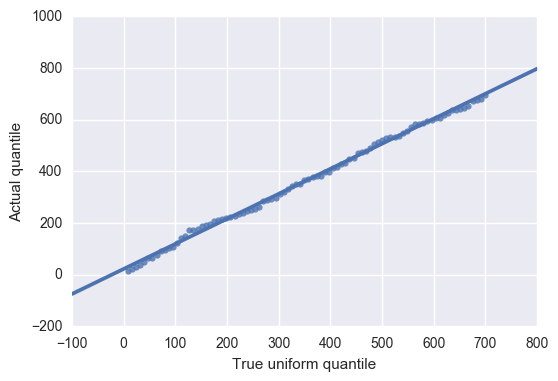

In [31]:
for url in pages_to_display[pages_to_display['Desc'] == "Normal"].index.values:
    print(url)
    (pdf_q, obs_q) = compute_q_q_pairs(url)
    sns.regplot(pdf_q, np.array(obs_q))
    plt.xlabel("True uniform quantile")
    plt.ylabel("Actual quantile")
    plt.show()

### Part 2

Describe your findings. 

In [32]:
# Use this cell for your explorations.
q7_p2_answer = r"""

The true uniform quantile is very close to the actual quantile. They are linearly correlated. They are approimatly
uniformly distributed.

"""

display(Markdown(q7_p2_answer))



The true uniform quantile is very close to the actual quantile. They are linearly correlated. They are approimatly
uniformly distributed.




---

## Question 8

Even if the updates were distributed uniformly, the Q-Q plot will not appear as exactly a straight line.  To get a sense of what a uniform-quantile plot might look like if the data were truly distributed according to the uniform distribution, simulate $n$ observations from the uniform distribution on the interval (0, 719) and make a uniform-quantile plot for these simulated data.  $n$ is defined in the next cell; write your code in the cell below that.

In [33]:
url = 'http://a.hatena.ne.jp/Syako/simple'
n = np.count_nonzero(crawls.loc[url]['updated'])

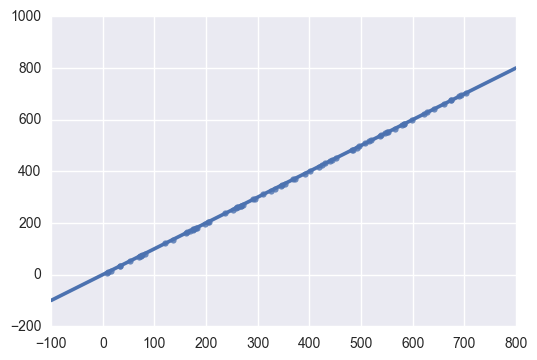

In [34]:
observations = np.random.uniform(0, 719, n)
sns.regplot(observations, observations)

# Leave this for grading purposes
q8_plot = plt.gcf()

How do the empirical quantile plots from the previous quesion compare to your simulated quantile plot?  *Optionally,* we suggest looking at a few other sites and a few other simulated sets of data to see how well they match.

In [35]:
# Use this cell for your explorations.
q8_answer = r"""

The simulated quantile plot has exactly linearly relationship but the empirical one does not exactly match.

"""

display(Markdown(q8_answer))



The simulated quantile plot has exactly linearly relationship but the empirical one does not exactly match.




---

# Estimating the Update Rate: A Simple Approach
How would you estimate the change rate for a page? 

For example, imagine that in 720 hourly visits to a page, we observed a change in the page on 36 visits. One estimate for the rate of changes is:

$$\frac {36\text{ changes}}{720\text{ hours}} = \frac{1}{20} \text{ changes per hour}$$

There is a small problem with our estimate. What if a page changes twice in an hour? We would see only one positive check.  We do not observe the true number of changes that happened to a page in 30 days, but the number of hours that had a change.  Think about how this could affect our interpretation of how often websites change.

To help answer this question, we use a probability model for the change behavior of a site and examine the impact of the incomplete observations on our simple estimate of a site's rate of change. 

## A Model for Page Updates
What model should we use?

In our earlier Q-Q plot analysis we found that the updates appear to occur uniformly at random.  

However, the number of positive checks (and therefore the number of page changes) is not the same from one page to the next. That is, both the *number* of changes and the hours of the changes appear to be random.

When events can happen independently at any point in a span of time, and they're equally likely to happen at any of the times, a good model for the *number* of events that happen is the Poisson distribution.

The Poisson distribution has a simple probability mass function, 

$$P(k) = \frac{\lambda^k}{k!}  e^{-\lambda},$$

for $k = 0, 1, 2, \ldots$. The parameter $\lambda$ is called the *rate*, and this is a Poisson$(\lambda)$ distribution.

For example, if $\lambda$ is the hourly rate of changes to a page, then the chance of $k$ changes in one hour is:

$$P(k) = \frac{\lambda^k}{k!}  e^{-\lambda}.$$

If we count the number of changes over $N$ hours, then the number of changes in this time period has 
a Poisson$(N \lambda)$ distribution. That is,  

$$P(k \texttt{ updates in }N \texttt{ hours}) = \frac{(N\lambda)^k}{k!}  e^{-(N\lambda)}.$$


---

## Question 9
Suppose that we observe $n$ changes for a site that was visited for $N$ hours. If the number of changes follows the Poisson distribution, show that $\frac{n}{N}$ is the MLE for $\lambda$.  In fancy notation, we could call this $\lambda^{\text{MLE}}$.  (Note that we are currently ignoring the problem of not being able to detect multiple changes in an hour.)

*Note:* It's okay to write your answer in plain text.  If you know $\LaTeX$ or would like to learn it, now is a good time to try it out.  (If you double-click on this cell or some of the cells above, you can see some $\LaTeX$ examples.)

In [36]:
q9_answer = r"""

Put your answer here and delete these two sentences.  Some
steps are already filled in to get you started; the '...'
indicate where you need to fill in one or more lines.

**Step 1.** The probability of the data given $\lambda$ is:

$$L(\lambda) = e^{-(\lambda N)} \frac{(\lambda N)^{n}}{n!}$$

$$l(\lambda) = ln(e^{-(\lambda N)}) + ln(\lambda N)^{n} - ln(n!)$$

$$ = -\lambda N + nln(\lambda N) - ln(n!)$$

$$\frac{\partial l}{\partial \lambda} = -N + \frac{n}{\lambda} = 0$$

Therefore,

$$\lambda^{\text{MLE}} = \frac{n}{N}$$

"""

display(Markdown(q9_answer))



Put your answer here and delete these two sentences.  Some
steps are already filled in to get you started; the '...'
indicate where you need to fill in one or more lines.

**Step 1.** The probability of the data given $\lambda$ is:

$$L(\lambda) = e^{-(\lambda N)} \frac{(\lambda N)^{n}}{n!}$$

$$l(\lambda) = ln(e^{-(\lambda N)}) + ln(\lambda N)^{n} - ln(n!)$$

$$ = -\lambda N + nln(\lambda N) - ln(n!)$$

$$\frac{\partial l}{\partial \lambda} = -N + \frac{n}{\lambda} = 0$$

Therefore,

$$\lambda^{\text{MLE}} = \frac{n}{N}$$




---

## Question 10

1. Add a `'simple mle'` column to the `crawl_stats` table containing the `'simple mle'` estimator we derived earlier for each website.

2. **Then,** make a plot that displays the distribution of these MLEs *for the sites with at least 700 crawls*.

In [37]:
crawl_stats.head()

,number of updates,number of crawls,proportion of updates,Desc
url,,,,
http://0968797090.blinklist.com/tag/%E5%8F%B0%E5%8C%97%E9%A0%82%E9%BB%9E%E7%AE%A1%E7%90%86%E5%A7%94%E5%93%A1%E6%9C%83/,0.0,245,0.000000,
http://202.155.15.208/koran_detail.asp?id=283292&kat_id=16&kat_id1=&kat_id2=,27.0,217,0.124424,
http://5eg.net/gallery/thumbnails.php?album=lastcom,13.0,378,0.034392,
http://5eg.net/gallery/thumbnails.php?album=lastcom&cat=0,13.0,378,0.034392,
http://86door.com.cn/,5.0,268,0.018657,


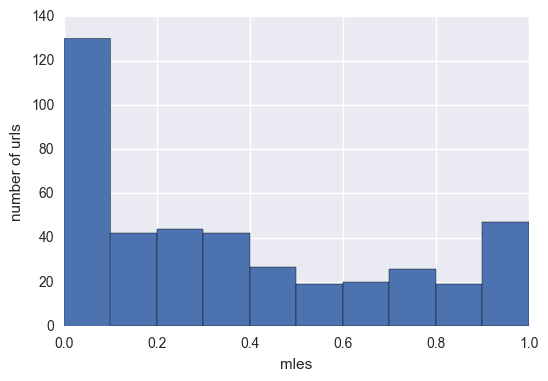

In [38]:
crawl_stats['simple mle'] = crawl_stats['number of updates']/crawl_stats['number of crawls']
chosen_crawl = crawl_stats[crawl_stats['number of crawls'] >= 700]
plt.hist(chosen_crawl['simple mle'])
plt.xlabel('mles')
plt.ylabel('number of urls')

# Leave this at the end so we can grab the plot for grading
q10_plot = plt.gcf()

In [39]:
_ = ok.grade('q10')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



## The Impact of Hourly Observations

The histogram that you made for previous problem has a small mode at 1. Why is this? It is not possible for our estimate of the rate of changes to be greater than once an hour because we only observe the page once an hour. So if the rate of changes is large, we are likely to underestimate it. Let's try to assess the impact of this.

We will carry out a Monte Carlo (repeated, randomized simulation) study of the process that generates our observations. To perform such a study, we need a model for how the checks came out. For that, we need a model for the page changes themselves.

We previously said that the number of changes follows a Poisson distribution with a certain rate for each page.  We also saw that the positive checks are distributed roughly uniformly.  It seems reasonable to assume that the changes themselves are also distributed uniformly.

When the *number* of events follows the Poisson distribution and the *location* of the events (along the time interval) follows the uniform distribution, then we have what is called a *Poisson process*.  This is a random object that's a *set* of numbers rather than just one *number*.

To perform our Monte Carlo study, for various values of $\lambda$ we will generate the simulated changes according to the Poisson process distribution and then *reduce* the changes to the hour of the change. More specifically, we can simulate the data as follows:

* Generate $M$, the number of updates, by drawing from the Poisson(720$\lambda$) distribution.
* Place each of the $M$ updates uniformly at random on the interval (0, 719). 
* "Snap" each update to the next hour.  For example, a 3:15 update time becomes 4:00, which is the time when we would have observed it. (What do you do when more than one update occurs within an hour?)

---

## Question 11
Following the above description of the Poisson process, complete the function `sample_poisson_process`.

*Hint:* The function `np.random.poisson` will be useful.

In [41]:
def sample_poisson_process(rate, length):
    """Generates n points from Poisson(rate*length) and locates them
    uniformly at random on [0, length].
    
    Args:
      rate (float): The average number of points per unit length.
      length (float): The length of the line segment.
    
    Returns:
      ndarray: An array of points scattered randomly on [0, length].
               The number of points has a Poisson(rate*length)
               distribution.
    """
    # Generate  M , the number of updates, by drawing from the Poisson(720 λ) distribution.
    M = np.random.poisson(length*rate)
    # Place each of the  M updates uniformly at random on the interval (0, 719)
    return np.random.uniform(0, length, M)

In [42]:
_ = ok.grade('q11')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



The `snap_times` function in the next cell will help you simulate the hourly observations from the crawler.

In [43]:
def snap_times(update_times, window_length, process_length):
    """Given a list of change times, produces a list of the windows that detected a
    change (that is, where at least one change happened inside the window).
    
    This has the effect of 'snapping' each change to the next hour (or whatever the
    window_length is).  For periods where more than one change happened, the output
    will still only list the period once.
    
    In other words, it produces a list of the positive checks given a list of true
    change times.
    
    Args:
      update_times (ndarray): A list of times when changes happened for a page.
                              All times are between 0 and process_length.
      window_length (float): The width of each window.  (For example, if time
                             is being measured in hours, and an observation
                             happens once per hour, then this should be 1.)
      process_length (float): The last time time any change could have happened.
    
    Returns:
      ndarray: A list of numbers, each one the right endpoint of a window where at
               least one change happened."""
    window_ends = np.arange(0, process_length, window_length) + window_length
    num_windows = len(window_ends)
    event_windows = np.floor(np.array(update_times) / window_length).astype(int)
    events_by_window = np.bincount(event_windows, minlength=num_windows)
    event_happened = events_by_window > 0
    return window_ends[event_happened]


---

## Question 12

Use the functions `sample_poisson_process` and `snap_times` to examine what happens when we visit hourly.  Look at examples where
* the `length` of time is 24 hours,
* the `rate` is 1/8, 1/4, 1/2, 1, and 2 changes per hour, and
* the `window_length` is 1.

For each value of `rate`, simulate one set of change on the interval (0 hours, 24 hours), and plot the resulting points on a timeline using `display_points`.  Then snap these data to the next hour with `snap_times` and plot the resulting positive check times.

**Then,** compare the actual change times to the censored times for the various rates. What happens as the rate changes? Do you think hourly visits to the site are a problem if the rate is 1/8? How about 2? 

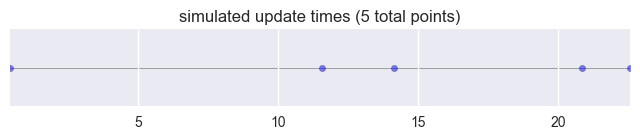

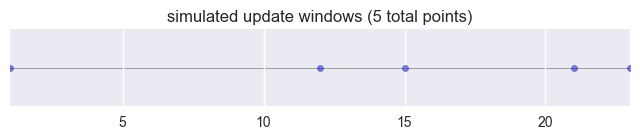

In [44]:
# rate = 1/8
update_times = sample_poisson_process(rate = 1/8, length = 24)
display_points(update_times, [min(update_times), max(update_times)], "simulated update times")
windows = snap_times(update_times, 1, 24)
display_points(windows, [min(windows), max(windows)], "simulated update windows")

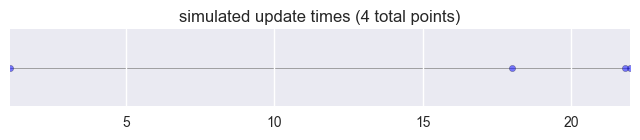

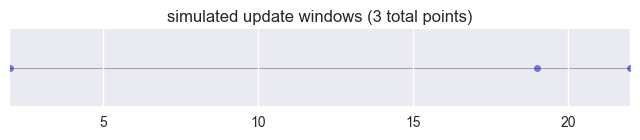

In [45]:
rate = 1/4
update_times = sample_poisson_process(rate, length = 24)
display_points(update_times, [min(update_times), max(update_times)], "simulated update times")
windows = snap_times(update_times, 1, 24)
display_points(windows, [min(windows), max(windows)], "simulated update windows")

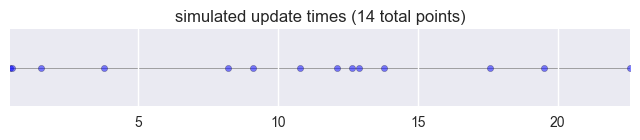

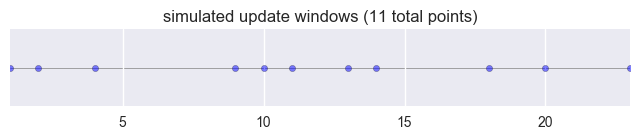

In [46]:
rate = 1/2
update_times = sample_poisson_process(rate, length = 24)
display_points(update_times, [min(update_times), max(update_times)], "simulated update times")
windows = snap_times(update_times, 1, 24)
display_points(windows, [min(windows), max(windows)], "simulated update windows")

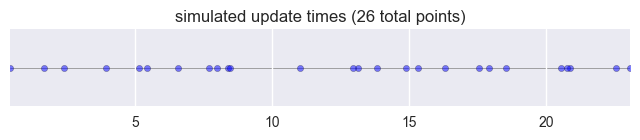

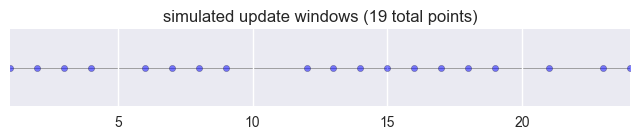

In [47]:
rate = 1
update_times = sample_poisson_process(rate, length = 24)
display_points(update_times, [min(update_times), max(update_times)], "simulated update times")
windows = snap_times(update_times, 1, 24)
display_points(windows, [min(windows), max(windows)], "simulated update windows")

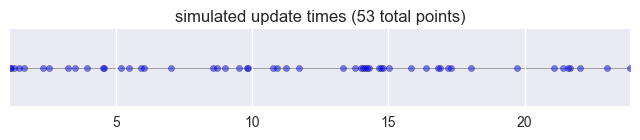

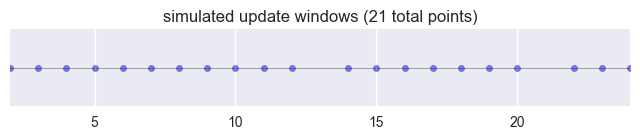

In [48]:
rate = 2
update_times = sample_poisson_process(rate, length = 24)
display_points(update_times, [min(update_times), max(update_times)], "simulated update times")
windows = snap_times(update_times, 1, 24)
display_points(windows, [min(windows), max(windows)], "simulated update windows")

In [49]:
# Use this cell for your explorations, then write your conclusions
# in the string below.
q12_answer = r"""

As the rate gets larger, the url updates more frequently. Hourly visits is not a problem when the rate = 1/8 because
within one hour, the url updates at least once at most of the time and rarely updates too much within a window size. 
However it is a problem when the rate = 2 because the url updates too much within one hour. The hourly visit does not 
catch all the updates.

"""

display(Markdown(q12_answer))



As the rate gets larger, the url updates more frequently. Hourly visits is not a problem when the rate = 1/8 because
within one hour, the url updates at least once at most of the time and rarely updates too much within a window size. 
However it is a problem when the rate = 2 because the url updates too much within one hour. The hourly visit does not 
catch all the updates.



## Simulation study of the rate estimate 
Now let us extend our Monte Carlo study to compute the MLE from the observed positive checks.  Since we know the true change rate in the simulations, we can compare the MLE to the true change rate and see how accurate it is as an estimator.  (We couldn't have done that with our real data, since we don't know the true change rates.)


---

## Question 13

Suppose a website is visited every hour for 30 days, so it has 719 visits.  For a particular rate $\lambda$, 

* Generate the observed positive checks with our earlier functions (`sample_poisson_process` and `snap_times`).
* Calculate the MLE from these simulated data.
* Repeat 1000 times.

This average estimate will change as we increase the true rate of changes, so vary $\lambda$ between 0 and 4 and make a plot showing the estimate as a function of $\lambda$.  For comparison, show the true change rates in your plot as well.

In [50]:
def simulate_censored_rate_estimate(true_rate, num_visits):
    """Simulates updates to a page and visits by a web crawler, and
    returns the proportion of visits in which an update was observed.
    
    Args:
      true_rate (float): The average number of updates per unit length
                         of time.  (The units are irrelevant for the
                         purposes of this function, but you can imagine
                         that they are hours.)
      num_visits (float): The number of visits made to the site.  One
                          visit is made per unit length of time, so
                          this is also equal to the duration of time
                          simulated.
    
    Returns:
      float: the MLE for true_rate lambda, based on the number of 
      observed positive checks.
    """
    # The skeleton here is provided for your convenience; you
    # don't have to follow it.
    draws = sample_poisson_process(true_rate, num_visits)
    windows = snap_times(draws, 1, num_visits)
    return len(windows)/num_visits


The following helper function can be used to simulate many rate estimates using the function you just completed.

In [51]:
def simulate_many_rate_estimates(true_rate, num_visits):
    return np.mean([simulate_censored_rate_estimate(true_rate, num_visits) 
                    for _ in range(1000)])

The following code will simulate rate estimates for various values of $\lambda$ (this cell may take up to 1 minute to run):

In [52]:
num_visits = 719
rates = list(np.arange(0, 4, .2))
estimates = [simulate_many_rate_estimates(r, num_visits) for r in rates]

Finally, the following code will plot the estimated values for $\lambda$ against their true values.  You will need this plot to answer the next question.

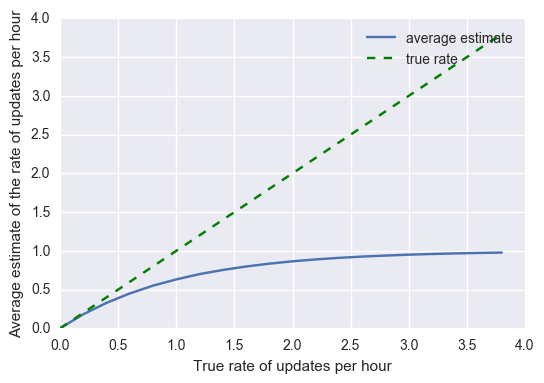

In [53]:
plt.plot(rates, estimates, label = 'average estimate');
plt.plot([rates[0], rates[-1]], [rates[0], rates[-1]], 
         linestyle='dashed', color='g', label='true rate')
plt.xlabel("True rate of updates per hour")
plt.ylabel("Average estimate of the rate of updates per hour")
plt.legend();

In [54]:
num_visits = 719
rates = list(np.arange(0, 4, .2))
quick_estimates = [simulate_censored_rate_estimate(r, num_visits) for r in rates]
0.27 < np.std(quick_estimates) < 0.29
print(np.std(quick_estimates))

0.278850847364


In [55]:
_ = ok.grade('q13')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



---

## Question 14

### Part 1
Explain why the estimated rates seem to level off at 1.

In [56]:
q14_p1_answer = r"""

because urls are checked once in one hour apart.

"""

display(Markdown(q14_p1_answer))



because urls are checked once in one hour apart.



### Part 2
How far off is the estimate from the truth for $\lambda$ less than 0.25?

In [57]:
q14_p2_answer = r"""

the estimate is really close to the truth when $\lambda$ is less than 0.25

"""

display(Markdown(q14_p2_answer))



the estimate is really close to the truth when $\lambda$ is less than 0.25



## Estimating the update rate: An improved approach
Our simulation study has shown us that our MLE estimate for the rate is biased. It systematically underestimates the quantity we're trying to estimate, the rate.  This bias is small for small $\lambda$, but can we eliminate it?

We can recast the problem slightly by reconsidering our observations. Although the possible times of a page changes may be continuous, we only observe the data hourly and we only observe whether there was at least one update in that hour.  Does this remind you of a distribution that you have worked with?

What if we consider the data for a page as 719 0-1 values, where 0 indicates no change and 1 indicates at least 1 change in the hour?  Do you see why these 0-1 values are equivalent to our representation of the data as positive changes?  For example, if `N` is 10 and we observe changes at hours 3, 7, and 9 then this information is equivalent to the sequence 0,0,1,0,0,0,1,0,1,0.  

The distribution of the 0-1 values is Bernoulli(`p`). Under our assumption that the changes come from a Poisson process, their values are independent.

This distribution incorporates the censoring of the data. How can we estimate the rate? We can use the Poisson distribution to compute the chance of a 0 or 1, which depends on the rate. Then we use the Bernoulli distribution to find the MLE of $\lambda$.

---

## Question 15
What is the chance that a Poisson($\lambda$) random variable is equal to 0?  What is the chance that it's greater than or equal to 1?

In [58]:
q15_answer = r"""

random variable = 0: $e^{-\lambda}$

random varibale = 1: 1 - $e^{-\lambda}$


"""

display(Markdown(q15_answer))



random variable = 0: $e^{-\lambda}$

random varibale = 1: 1 - $e^{-\lambda}$




To check your answers, fill in the numerical values of each probability, for $\lambda=0.5$

In [59]:
# The probability that a Poisson(0.5) random variable is equal to 0
Prob_pois_half_equals_0 = np.exp(-0.5)
# The probability that a Poisson(0.5) random variable is greater than or equal to 1
Prob_pois_half_gte_1 = 1 - Prob_pois_half_equals_0

In [62]:
_ = ok.grade('q15')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



---

## Question 16
With this modified model, the MLE of $\lambda$, given $n$ updates in $N$ visits for a site, is:

$$\lambda^* = \log \left(\frac{n}{N - n} + 1 \right)$$

Show that that's true.

*Hint:* If you find an expression like $\frac{e^{-\lambda}}{1 - e^{-\lambda}}$, it often helps to convert such an expression to $\frac{1}{e^{\lambda} - 1}$ by multiplying its numerator and denominator by $e^{\lambda}$.

In [63]:
q16_answer = r"""

$P(0) = e^{-\lambda}$, $P(1) = 1-e^{-\lambda}$

$L(\lambda) = (e^{-\lambda})^(N-n)(1-e^{-\lambda})^n$

$l(\lambda) = (N-n)ln(e^{-\lambda}) + nln(1-e^{\lambda}) = -\lambda (N-n) + nln(1-e^{-\lambda})$

$\frac{\partial l}{\partial \lambda} = -(N-n) + n\frac{1}{1-e^{-\lambda}}e^{-\lambda} = 0$

$ = -(N-n) + n\frac{e^{-\lambda}}{1-e^{-\lambda}} = 0$

$n\frac{1}{e^{\lambda} - 1} = N-n$

$e^{\lambda} - 1 = \frac{n}{N-n}$

$\lambda = ln(\frac{n}{N-n}+1)$

"""

display(Markdown(q16_answer))



$P(0) = e^{-\lambda}$, $P(1) = 1-e^{-\lambda}$

$L(\lambda) = (e^{-\lambda})^(N-n)(1-e^{-\lambda})^n$

$l(\lambda) = (N-n)ln(e^{-\lambda}) + nln(1-e^{\lambda}) = -\lambda (N-n) + nln(1-e^{-\lambda})$

$\frac{\partial l}{\partial \lambda} = -(N-n) + n\frac{1}{1-e^{-\lambda}}e^{-\lambda} = 0$

$ = -(N-n) + n\frac{e^{-\lambda}}{1-e^{-\lambda}} = 0$

$n\frac{1}{e^{\lambda} - 1} = N-n$

$e^{\lambda} - 1 = \frac{n}{N-n}$

$\lambda = ln(\frac{n}{N-n}+1)$



What happens when we observe a change every hour?  Then, our MLE $\lambda^*$ takes the value $\infty$.  

Why is that true? Intuitively, if there is a change on each visit, we can always increase the likelihood of our data (which is the likelihood that every hour saw at least one change) by increasing $\lambda$.

An MLE of $\infty$ is clearly problematic. We can use the idea of Laplace smoothing to modify the estimator a bit.  We'll use the following "modified MLE" estimator, which adds to every site a single imagined visit where "half" saw a change and the other "half" didn't:

$$\lambda^+ = \log \left(\frac{n + .5}{N - n + .5} + 1 \right)$$

You can imagine that this estimate incorporates a prior conservative intuition that a site might not change all the time even if it happened to change every hour in the particular 30-day period we observed.


---


## Question 17


1. Add a `'modified mle'` column to the `crawl_stats` table containing the `'modified mle'` estimator $\lambda^+$ for each website.

2. **Then,** make a histogram that displays the distribution of the modified MLEs *for the sites with at least 700 crawls*.

*Hint:* You may find your work in question 10 helpful.

In [64]:
crawl_stats.head()

,number of updates,number of crawls,proportion of updates,Desc,simple mle
url,,,,,
http://0968797090.blinklist.com/tag/%E5%8F%B0%E5%8C%97%E9%A0%82%E9%BB%9E%E7%AE%A1%E7%90%86%E5%A7%94%E5%93%A1%E6%9C%83/,0.0,245,0.000000,,0.000000
http://202.155.15.208/koran_detail.asp?id=283292&kat_id=16&kat_id1=&kat_id2=,27.0,217,0.124424,,0.124424
http://5eg.net/gallery/thumbnails.php?album=lastcom,13.0,378,0.034392,,0.034392
http://5eg.net/gallery/thumbnails.php?album=lastcom&cat=0,13.0,378,0.034392,,0.034392
http://86door.com.cn/,5.0,268,0.018657,,0.018657


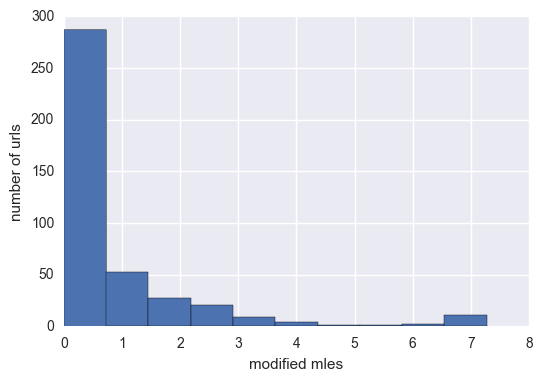

In [65]:
n = crawl_stats['number of updates']
N = crawl_stats['number of crawls']
crawl_stats['modified mle'] = np.log((n+0.5)/(N-n+0.5)+1)
chosen_crawl = crawl_stats[crawl_stats['number of crawls'] >= 700]
plt.hist(chosen_crawl['modified mle'])
plt.xlabel('modified mles')
plt.ylabel('number of urls')

q17_plot = plt.gcf()

In [66]:
_ = ok.grade('q17')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



Notice that this distribution is quite different than the earlier one we found in question 10. Now there is not a pile up of estimates at 1. 

## How accurate are our estimates?

We don't know the true update rates of the pages, so we can't know exactly how accurate our estimates are.  But this is often the case in data science.  Let's try to figure out a reasonable way to *estimate* the accuracy of our estimates.

The strategy is similar to the bootstrap.  In pseudocode:

`for each page ` $i$ `:`

`... Assume the true change rate ` $r_i$ ` equals our estimate ` $\lambda^+_i$.

`... for _ in range(num_simulations):`

`...     Simulate changes and positive checks.`

`...     Compute a new maximum likelihood estimate of ` $r_i$ ` based on the simulated data.`

`... Plot these estimates in a histogram or summarize them in some other way.`

This is called a *parametric* bootstrap method, because instead of resampling directly from our data, we use our data to estimate its distribution's parameters and then sample from that distribution.

---

## Question 18
Complete the definitions of `simulate_change_rate_estimate` and `modified_mle` in the cell below.

In [214]:
def simulate_change_rate_estimate(change_rate, num_observations, estimator):
    """Simulates hourly change observations for a website and produces an
    estimate of the change rate.
    
    Args:
      change_rate (float): The hourly change rate of the website to be used in
                           the simulation.
      num_observations (int): The number of observations (equivalently, the
                              number of hours) to simulate.
      estimator (func): A function to apply to the simulated observations to
                        produce an estimate of the change rate.  Has the same
                        signature as the function modified_mle below.
    
    Returns:
      float: The estimate produced by calling estimator on the simulated
             list of positive checks.
    """
    update_times = sample_poisson_process(rate = change_rate, length = num_observations)
    positive_checks = snap_times(update_times, window_length = 1, process_length = num_observations)
    return estimator(positive_checks, num_observations)


def modified_mle(positive_checks, num_observations):
    """Produces the modified MLE for a dataset.
    
    Args:
      positive_checks (ndarray): A list or array of the hours when a
                                 change was observed.
      num_observations (int): The number of hours in which we could
                              have observed a change.
    
    Returns:
      (float): The modified MLE.
    """
    n = len(positive_checks)
    N = num_observations
    modified_mle = np.log((n+0.5)/(N-n+0.5)+1)
    return modified_mle

In [215]:
_ = ok.grade('q18')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu



---

## Question 19

Complete the definition of `plot_bootstrap_rate_estimates` in the cell below.  **Read the docstring** carefully so you know what to do. **Then** run the provided cell below that to plot the bootstrap rate estimate distributions for a few pages.

In [171]:
def plot_bootstrap_rate_estimates(page_url, num_simulations):
    """Simulates positive check observations for a website many times.  For
    each simulation, the page's change rate is estimated based on the simulated
    positive checks.  The estimation method is the modified_mle function
    implemented above.  Then this function produces a histogram that shows
    the distribution of these estimated change rates.
    
    When conducting each simulation, the change rate is taken to be the
    estimated update rate for the page.  *That* estimate is the modified
    MLE computed from the actual positive check observations for that page.
    
    The modified MLE computed from the actual observations for the page
    is also displayed as a vertical red line at an appropriate horizontal
    position on the histogram.
    
    Here is a diagram that might be helpful:
    
                                             (This happens 1 time)
                                                     |
                                                     v
    Positive check observations for this page ---modified_mle---> Estimate of change rate for this page
    
                                   (1000x, once per simulation)
    Estimate of change rate for this page ---simulation---> Simulated positive checks
    
                          (1000x, once per simulation)
    Simulated positive checks ---modified_mle---> Bootstrap estimate of change rate for this page
    
    1000 bootstrap estimates of change rate for this page ---> Histogram
                                                               ^
                                        (displayed somewhere)  |
    Estimate of change rate for this page --------------------/
    
    Args:
      page_url (str): The URL of the page to simulate.
      num_simulations (int): The number of simulations to run.
    
    Returns:
      None: This function doesn't return anything; it just makes a histogram
      appear as described above.
    """
    change_rate = crawl_stats[crawl_stats.index==page_url]['modified mle'][0]
    sim = lambda: simulate_change_rate_estimate(change_rate, 24, modified_mle)
    estimate_mles = [sim() for _ in range(num_simulations)]
    plt.hist([change_rate]+estimate_mles)
    plt.axvline(change_rate, color='r')
    plt.xlabel('estimate change rates')
    plt.ylabel('amount')
    plt.show()
    

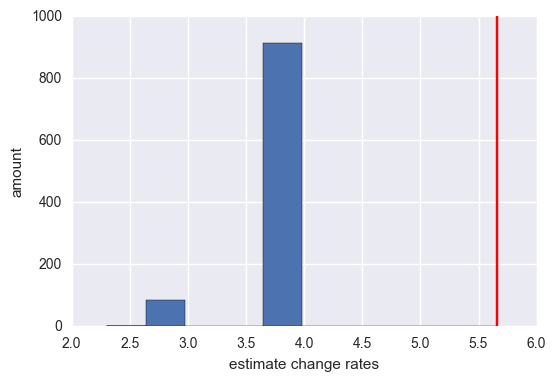

In [172]:
# Run this cell to make plots for several pages using your
# function.  Since no automatic tests are provided for this
# question, we suggest examining the plots to make sure they
# make sense to you.
many_updates_url = crawl_stats[np.logical_and(
    crawl_stats['number of crawls'] >= 700,
    np.logical_and(
        .2 <= crawl_stats['proportion of updates'],
        crawl_stats['proportion of updates'] >= .8))].index[0]
plot_bootstrap_rate_estimates(many_updates_url, 1000)

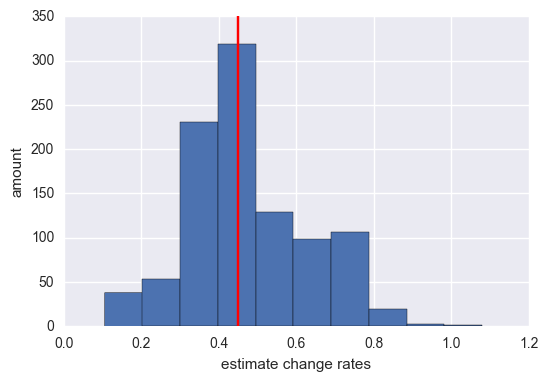

In [173]:
few_updates_url = crawl_stats[np.logical_and(
    crawl_stats['number of crawls'] >= 700,
    np.logical_and(
        .05 <= crawl_stats['proportion of updates'],
        crawl_stats['proportion of updates'] >= .15))].index[0]
plot_bootstrap_rate_estimates(few_updates_url, 1000)

Looking at the error distribution is good, but it's also useful to characterize error with a single number.  (This facilitates comparisons among different estimators, for example.)

A common way to summarize error in estimation is the root mean squared error, or RMSE.  The RMSE is the square root of the MSE, or mean square error. We calculate the MSE as follows:

* the average (across many simulations, where each simulation results in 1 estimate) of
* the squared difference between the estimate and its actual value.

Working with the RMSE, rather than the MSE, is useful when we want to understand the magnitude of error relative to the estimates.

We don't know the true change rate for each website, so we can't compute the true MSE.  However, if we find the MSE using the data making up the histogram you produced in the previous question, using the original estimate (the red line) as the actual change rate, that is a *bootstrap estimate* of the RMSE.

## Question 20

---

Complete the definition of `estimate_rmse` in the cell below.  **Then**, use it to estimate the RMSE for each page's modified MLE.  Add these RMSEs as a column named `'rmse'` in `crawl_stats`.

**Note**: There are 1000 pages, so this will take some time.  We recommend using only 100 simulations per page, which should be sufficient for reasonable estimates.  Try your code on a single page before running it on every page.

In [351]:
def estimate_rmse(page_url, num_simulations):
    """Simulates update observations for a website many times.  For each
    simulation, the page's change rate is estimated based on the simulated
    observations.  (The estimation method is the modified MLE.)  Then this
    function produces an estimate of the RMSE of estimates of the change
    rate for this page.
    
    When conducting each simulation, the change rate is taken to be the
    estimated change rate for the page.  *That* estimate is the modified
    MLE computed from the actual observations for the page.
    
    We compute the modified MLE for each set of simulated observations.  That
    constitutes num_simulations estimates of the change rate.
    
    Then we compute the RMSE of those estimates.  The "true" change rate in
    that calculation is taken to be the modified MLE computed from the
    actual observations for the page.
    
    Args:
      page_url (str): The URL of the page to simulate.
      num_simulations (int): The number of simulations to run.
    
    Returns:
      float: The estimated RMSE of the modified MLE for the given page,
             based on num_simulations simulations.
    """
    true_rate = crawl_stats[crawl_stats.index==page_url]['modified mle'][0]
    change_rate = true_rate
    sim = lambda: simulate_change_rate_estimate(change_rate, 440, modified_mle)
    estimate_mles = [sim() for _ in range(num_simulations)]
    return np.sqrt(np.mean(np.square(estimate_mles - true_rate)))
    '''
    diff = []
    for _ in range(num_simulations):
        change_rate1 = simulate_change_rate_estimate(change_rate, 720, modified_mle)
        diff.append(np.square(change_rate-change_rate1))
        change_rate = change_rate1
    return np.sqrt(np.mean(diff))
    '''
    
print(estimate_rmse(many_updates_url, 1000))
print(estimate_rmse(few_updates_url, 1000))

0.72698249223
0.0370641489487


In [356]:
# After completing estimate_rmse above, estimate the RMSEs for all
# the pages here, and add them to crawl_stats as a new column named
# 'rmse'.
rmses = [estimate_rmse(page_url, 1000) for page_url in crawl_stats.index]
crawl_stats['rmse'] = rmses

In [357]:
int(crawl_stats['rmse'].mean()*1000)

66

In [358]:
int(crawl_stats['rmse'].std()*1000)

138

In [359]:
_ = ok.grade('q20')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% completee
Backup successful for user: jtan0325@berkeley.edu



---

## Question 21
Create a visualization to display the RMSEs you computed.  **Then,** create another visualization to see the relationship (across the 1000 pages) between RMSE and the modified MLE.

In [360]:
crawl_stats.head()

,number of updates,number of crawls,proportion of updates,Desc,simple mle,modified mle,rmse
url,,,,,,,
http://0968797090.blinklist.com/tag/%E5%8F%B0%E5%8C%97%E9%A0%82%E9%BB%9E%E7%AE%A1%E7%90%86%E5%A7%94%E5%93%A1%E6%9C%83/,0.0,245,0.000000,,0.000000,0.002035,0.002464
http://202.155.15.208/koran_detail.asp?id=283292&kat_id=16&kat_id1=&kat_id2=,27.0,217,0.124424,,0.124424,0.134843,0.018260
http://5eg.net/gallery/thumbnails.php?album=lastcom,13.0,378,0.034392,,0.034392,0.036270,0.009229
http://5eg.net/gallery/thumbnails.php?album=lastcom&cat=0,13.0,378,0.034392,,0.034392,0.036270,0.009105
http://86door.com.cn/,5.0,268,0.018657,,0.018657,0.020658,0.007097


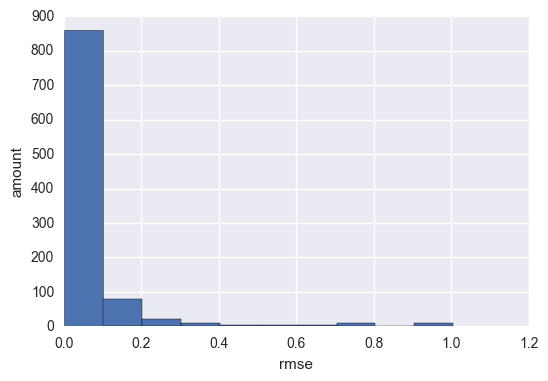

In [363]:
# RMSEs visual
plt.hist(crawl_stats['rmse'])
plt.xlabel('rmse')
plt.ylabel('amount')
plt.show()

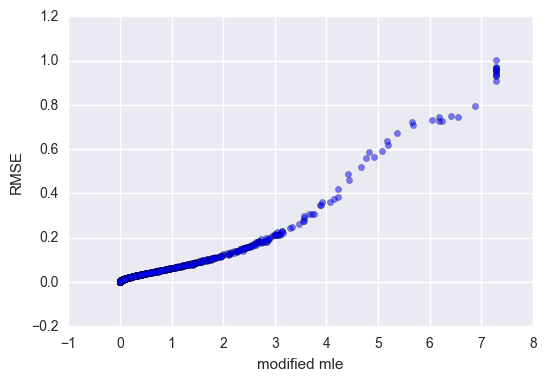

In [364]:
# relationship of RMSEs and modified MLE
plt.scatter(x = crawl_stats['modified mle'], y = crawl_stats['rmse'], alpha=0.5)
plt.xlabel('modified mle')
plt.ylabel('RMSE')
plt.show()

## Is the model reasonable?
All the foregoing work has assumed a particular probability model for website updates: the number of changes follows a Poisson($\lambda$) distribution and the locations of the changes, given the number of changes, follows a uniform distribution.  Like most models, this is certainly imperfect.  However, it still may produce reasonable estimates. Let's check some of the conditions of the model to see if they are reasonable.

Embedded in our model is the assumption that the rate of changes for a page is constant over time.  If we find a strong pattern in the rates of updates, that is evidence against this assumption.  For example, you might guess that changes for certain pages might happen more often at certain times of the day, or on certain days of the week.

Before you group by day of week, here are some difficulties presented by the dataset:

1. The day of the week is not given.
2. The hour of the day is not given.
3. We don't know when the checks started.
4. When a site had a failed check, the check was just omitted from the dataset, so we don't know when the failed checks happened, only their total count for each page.
5. Not all sites are in the same or nearby time zones.

Here is what we *do* know:

1. Checks for all pages started at the same time, at midnight PST (US Pacific Coast time).
2. Checks were attempted every hour for 30 days, and then they stopped.
3. We know each page's URL.  A URL may tell us something about its geography and therefore its rough time zone.  For example, the top-level domains `.edu`, `.com`,`.gov`, and `.net` include only US sites.

---

## Question 22
Propose a ***plan*** to answer one of these questions:

1. How much did the rate of changes vary by hour of the day?
2. How much did the rate of changes vary by day of the week?

**Or,** you may choose your own pattern to test.

Your plan doesn't need to produce results that hold for *all* pages, only a reasonably-large subset.  Be sure to make clear exactly what question your analysis would answer.

**Note**: You don't need to actually implement your plan!

In [365]:
# Feel free to use this cell to experiment.  Then write your answer
# in the string below.
q22_answer = r"""

To answer the question "How much did the rate of changes vary by hour of the day?", we need to check urls every minute
and mark if it is the same as the last time we check it (True = different, False = Same).

Count the amount of Trues in every 60 checks. That is the rate of changes in one hour. Record the rate of changes in
every 60-checks interval. Then compare the rate of changes in one interval to the one in other intervals. 

"""

display(Markdown(q22_answer))



To answer the question "How much did the rate of changes vary by hour of the day?", we need to check urls every minute
and mark if it is the same as the last time we check it (True = different, False = Same).

Count the amount of Trues in every 60 checks. That is the rate of changes in one hour. Record the rate of changes in
every 60-checks interval. Then compare the rate of changes in one interval to the one in other intervals. 



# Submitting your assignment
Congratulations, you're done with this homework!

Run the next cell to run all the tests at once.

In [366]:
_ = ok.grade_all()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------

**Finally**, run the next cell to submit the assignment to OkPy so that the staff will know to grade it. You can submit as many times as you want, and you can choose which submission you want us to grade by going to https://okpy.org/cal/data100/sp17/.  After you've done that, make sure you've pushed your changes to Github as well!

In [367]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw5.ipynb'.
Backup... 100% complete
Backup successful for user: jtan0325@berkeley.edu

